### 2018/2019 - Task List 11

1. Utilize pyro Latent Dirichlet Allocation community implementation to perform experiments with text and provide insights from the results:
    - https://ws.clarin-pl.eu/public/teksty/2mini.zip
    - https://ws.clarin-pl.eu/public/teksty/2autorow.zip    
    - https://ws.clarin-pl.eu/public/teksty/5_autorow_skrot.zip
2. Compare the obtained results with another implementation of LDA.

REMARK! Please do not care about linguistic issues (lematization, disambiguation, etc.)

# Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from wordcloud import WordCloud
from gensim import corpora, models
import collections
import random

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

In [25]:
stop_words = get_stop_words('pl')
stop_words.append('i')
stop_words.append('w')
stop_words.append('a')
stop_words.append('z')
stop_words.append('o')
stop_words.append('ale')
stop_words.append('aby')
stop_words.append('ze')
stop_words.append('za')
stop_words.append('ani')
stop_words.append('które')
stop_words.append('który')
stop_words.append('nad')
stop_words.append('było')
stop_words.append('był')
stop_words.append('była')
stop_words.append('teraz')
stop_words.append('tylko')
stop_words.append('tego')
stop_words.append('gdy')
stop_words.append('przez')
stop_words.append('jeszcze')
stop_words.append('także')
stop_words.append('coś')
stop_words.append('sobie')
stop_words.append('tej')
stop_words.append('ta')
stop_words.append('ten')
stop_words.append('tym')
stop_words.append('przy')
stop_words.append('ot')
stop_words.append('która')
stop_words.append('aż')
stop_words.append('też')
stop_words.append('której')
stop_words.append('znowu')
stop_words.append('żeby')
stop_words.append('lecz')
stop_words.append('te')
stop_words.append('niby')
stop_words.append('tych')
stop_words.append('były')
stop_words.append('nawet')
stop_words.append('swej')
stop_words.append('których')
stop_words.append('trzeba')
stop_words.append('dopiero')
stop_words.append('zaraz')
stop_words.append('jednak')
stop_words.append('cóż')
stop_words.append('u')
stop_words.append('tem')
stop_words.append('pan')
stop_words.append('pani')
stop_words.append('panna')
stop_words.append('którą')
stop_words.append('miał')
stop_words.append('oj')
stop_words.append('gdyż')
stop_words.append('potem')
stop_words.append('ów')
stop_words.append('pana')
stop_words.append('panu')
stop_words.append('e')
stop_words.append('k')
stop_words.append('d')
stop_words.append('j')
stop_words.append('h')
stop_words.append('y')
stop_words.append('b')
stop_words.append('p')
stop_words.append('m')
stop_words.append('ż')
stop_words.append('l')
stop_words.append('by')
stop_words.append('ł')
stop_words.append('tę')

In [29]:
def get_most_common(array, num):
    counter = collections.Counter(array)
    x = [[i[0]] * int(i[1]/5) for i in counter.most_common(num)]
    z = []
    for i in range(len(x)):
        z += x[i]
    random.shuffle(z)
    return z

def read_doc(name, num=50):
    f = open(name, encoding="cp1250")
    doc = f.read()
    tokenizer = RegexpTokenizer(r'\w+')
    raw = doc.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in stop_words]
    return get_most_common(stopped_tokens, num)

In [30]:
doc_1 = read_doc("orzeszkowa_argonauci.txt")
doc_2 = read_doc("orzeszkowa_dziurdziowie.txt")
doc_3 = read_doc("zeromski_syzyfoweprace.txt")
doc_4 = read_doc("zeromski_wiernarzeka.txt")
doc_5 = read_doc("zeromski_zamiec.txt")
# doc_6 = read_doc("prus_faraon.txt")
# doc_7 = read_doc("prus_lalka.txt")
# doc_8 = read_doc("reymont_fermenty.txt")
# doc_9 = read_doc("reymont_komediantka.txt")

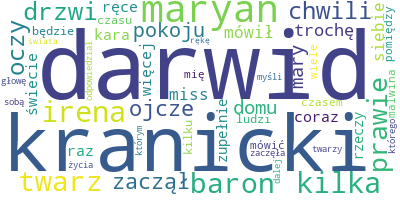

In [31]:
wordcloud = WordCloud(background_color="white", contour_width=3, contour_color='steelblue')
wordcloud.generate(','.join(doc_1))
wordcloud.to_image()

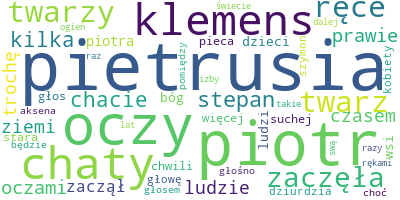

In [32]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(','.join(doc_2))
wordcloud.to_image()

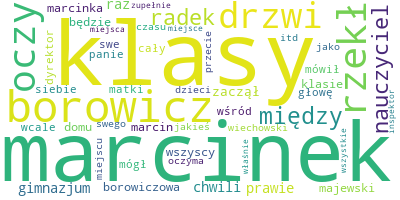

In [34]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(','.join(doc_3))
wordcloud.to_image()

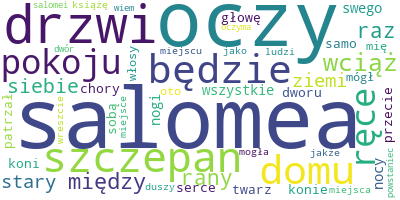

In [35]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(','.join(doc_4))
wordcloud.to_image()

In [36]:
# texts = [doc_1, doc_2, doc_3, doc_4, doc_5, doc_6, doc_7, doc_8, doc_9]
texts = [doc_1, doc_2, doc_3, doc_4, doc_5]
dictionary = corpora.Dictionary(texts)
data = []
data.append(torch.FloatTensor(dictionary.doc2idx(doc_1)))
data.append(torch.FloatTensor(dictionary.doc2idx(doc_2)))
data.append(torch.FloatTensor(dictionary.doc2idx(doc_3)))
data.append(torch.FloatTensor(dictionary.doc2idx(doc_4)))
data.append(torch.FloatTensor(dictionary.doc2idx(doc_5)))
# data.append(torch.FloatTensor(dictionary.doc2idx(doc_6)))
# data.append(torch.FloatTensor(dictionary.doc2idx(doc_7)))
# data.append(torch.FloatTensor(dictionary.doc2idx(doc_8)))
# data.append(torch.FloatTensor(dictionary.doc2idx(doc_9)))

In [37]:
arr = []
for i in range(len(data)):
    arr += data[i].tolist()
V = len(set(np.array(arr).ravel()))
K = 5
D = 5
# N = [len(doc_1),len(doc_2),len(doc_3),len(doc_4),len(doc_5),len(doc_6),len(doc_7),len(doc_8),len(doc_9)]
N = [len(doc_1),len(doc_2),len(doc_3),len(doc_4),len(doc_5)]

def model(data):
    phi = pyro.sample("phi",dist.Dirichlet(torch.ones([K, V])).independent(1))
  
    for d in pyro.plate("documents", D):
        theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(torch.ones([K])))
    
        with pyro.plate("words_%d"%d, N[d]):
            z = pyro.sample("z_%d"%d, dist.Categorical(theta_d))
            pyro.sample("w_%d"%d, dist.Categorical(phi[z]), obs=data[d])

def guide(data):
    beta_q = pyro.param("beta_q", torch.ones([K, V]),constraint=constraints.positive)
    phi_q = pyro.sample("phi",dist.Dirichlet(beta_q).independent(1))
  
    for d in pyro.plate("documents", D):
        alpha_q = pyro.param("alpha_q_%d"%d, torch.ones([K]),constraint=constraints.positive)
        q_theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(alpha_q))
    
        with pyro.plate("words_%d"%d, N[d]):
            q_i = pyro.param("q_%d"%d, torch.randn([N[d], K]).exp(), constraint=constraints.simplex)
            pyro.sample("z_%d"%d, dist.Categorical(q_i))

In [38]:
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

losses = []
for _ in tqdm(range(5000)):
    loss = svi.step(data)
    losses.append(loss)

Text(0, 0.5, 'loss')

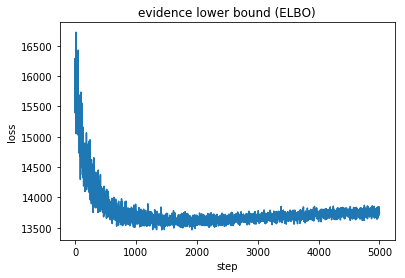

In [39]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")

In [40]:
pyro.get_param_store().get_all_param_names()

dict_keys(['beta_q', 'alpha_q_0', 'q_0', 'alpha_q_1', 'q_1', 'alpha_q_2', 'q_2', 'alpha_q_3', 'q_3', 'alpha_q_4', 'q_4'])

In [41]:
for p in pyro.get_param_store().get_all_param_names():
    print(p + ": " + str(pyro.param(p)))

beta_q: tensor([[ 5.1895, 12.9299,  8.7522,  3.7251,  5.2025,  6.7027,  3.5297,  8.8180,
          9.4287, 10.4840,  6.8621,  5.6784,  3.1875,  7.6738,  2.9543,  4.9220,
          3.5883,  3.6173,  6.2944,  2.2281,  4.8164,  5.3664,  3.4293,  6.8517,
          4.9079,  3.1285,  6.3864, 17.3953,  3.3930,  5.7590,  6.8366,  4.2841,
          9.9439, 11.6588,  5.9179,  6.7869,  2.3221,  9.4968,  4.6858,  6.5551,
          9.0067,  5.6605,  2.4949,  4.1911,  7.1016,  4.6408,  4.4791,  2.7477,
          5.2561,  3.8939,  2.7436,  3.7069,  2.9166,  5.4712,  3.2888,  4.0404,
          1.7625,  2.7187,  2.2975,  2.2751,  2.5515,  2.9631,  2.5436,  2.1635,
          2.2703,  3.7340,  2.5139,  2.4818,  5.5906,  4.7702,  2.3587,  2.0355,
          2.2559,  1.8295,  3.8796,  3.1485,  4.5238,  2.4405,  2.8038,  3.0646,
          5.5207,  6.0156,  2.6087,  1.8125,  2.5092,  3.1344,  2.1551,  2.2194,
          4.0210,  3.0296,  2.9971,  5.8576,  2.6333,  2.3444,  6.3951,  2.5087,
          1.9823,  3

        [0.0264, 0.1688, 0.1564, 0.0877, 0.5607]], grad_fn=<DivBackward0>)
alpha_q_1: tensor([42.3120, 45.1621, 46.3918, 43.8871, 42.6693], grad_fn=<AddBackward0>)
q_1: tensor([[0.6596, 0.2301, 0.0477, 0.0167, 0.0459],
        [0.1483, 0.2287, 0.3488, 0.2486, 0.0256],
        [0.0197, 0.1187, 0.0315, 0.0725, 0.7576],
        ...,
        [0.0678, 0.4946, 0.1689, 0.1096, 0.1591],
        [0.0324, 0.3539, 0.3643, 0.0116, 0.2378],
        [0.0275, 0.6585, 0.1324, 0.1157, 0.0660]], grad_fn=<DivBackward0>)
alpha_q_2: tensor([42.4062, 45.7054, 42.7049, 41.3902, 43.2706], grad_fn=<AddBackward0>)
q_2: tensor([[0.3519, 0.3625, 0.1249, 0.0439, 0.1167],
        [0.8611, 0.0727, 0.0241, 0.0181, 0.0241],
        [0.0652, 0.3603, 0.3959, 0.0920, 0.0866],
        ...,
        [0.1216, 0.2101, 0.1293, 0.5168, 0.0222],
        [0.3235, 0.1899, 0.0455, 0.3793, 0.0619],
        [0.3367, 0.0738, 0.1417, 0.1288, 0.3190]], grad_fn=<DivBackward0>)
alpha_q_3: tensor([37.4361, 35.1680, 37.8806, 38.7606, 42.385

In [42]:
V

159

[47.242774963378906, 46.449981689453125, 48.40932846069336, 47.5250244140625, 46.351863861083984]


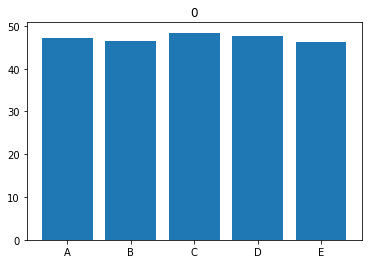

[42.31202697753906, 45.16207504272461, 46.391841888427734, 43.887123107910156, 42.6693229675293]


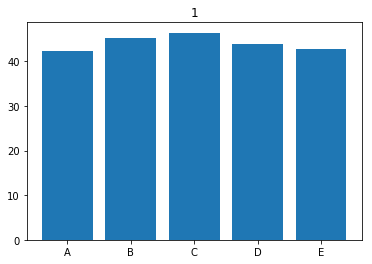

[42.40618133544922, 45.70539093017578, 42.70491027832031, 41.39019012451172, 43.27061080932617]


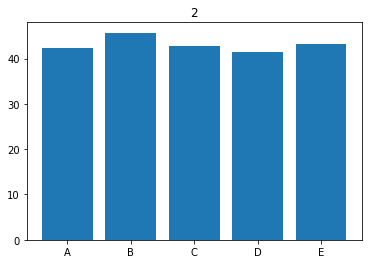

[37.43605041503906, 35.16804122924805, 37.88056945800781, 38.760616302490234, 42.38497543334961]


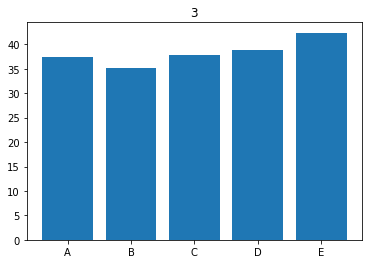

[41.90109634399414, 43.67766571044922, 44.6217155456543, 46.704280853271484, 41.8797607421875]


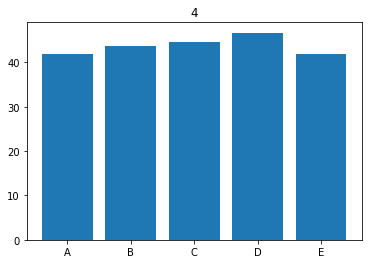

In [55]:
for i in range(D):
    d = pyro.param('alpha_q_'+str(i)).tolist()
    print(d)
    plt.close()
    bars = ('A', 'B', 'C', 'D', 'E')
    plt.bar(np.arange(len(d)), d)
    plt.xticks(np.arange(len(d)), bars)
    plt.title(str(i))
    plt.show()

In [64]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [65]:
import gensim
from gensim import corpora, models
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)
ldamodel.print_topics(num_topics=5, num_words=3)

[(0, '0.053*"darwid" + 0.035*"kranicki" + 0.032*"maryan"'),
 (1, '0.046*"marcinek" + 0.046*"klasy" + 0.044*"borowicz"'),
 (2, '0.048*"salomea" + 0.040*"oczy" + 0.038*"drzwi"'),
 (3, '0.054*"pietrusia" + 0.042*"piotr" + 0.035*"oczy"'),
 (4, '0.070*"nienaski" + 0.044*"xenia" + 0.034*"raz"')]

In [66]:
print('LDA sklearn')
for i in range(D):
    print("Document " + str(i) + ": " + str(ldamodel[corpus[i]]))

Document 0: [(0, 0.9987871)]
Document 1: [(3, 0.9983713)]
Document 2: [(1, 0.9983673)]
Document 3: [(2, 0.9976685)]
Document 4: [(4, 0.9983867)]


In [69]:
print('LDA pyro')
for i in range(D):
    d = pyro.param('alpha_q_'+str(i)).tolist()
    print(d.index(min(d)))
#     print("Document " + str(i) + ": " + str(ldamodel[corpus[i]]))

LDA pyro
4
0
3
1
4
